# Water level Bottle image Classification

# Your proposed models should reach atleast at  80% of accuracy

### Imported libraries

This starter code version for tensor flow however you are allowed to implement similar approach using any other libraries

In [4]:
# Import necessary libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import logging

# Set up logging to capture TensorFlow warnings and errors
logging.basicConfig(level=logging.ERROR, filename='tensorflow.log', filemode='w')


### Set all parameters

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
CHANNELS= 3
EPOCHS= 50

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import data into tensorflow dataset object

In [6]:
# This implemented using the google drive bbu wherever using the local jupyter, the following file path in comment can be used
# data_directory = 'Water Bottle Image Dataset'

# The path to dataset directory
data_directory = '/content/drive/MyDrive/Colab Notebooks/ACV/oirakoze/part2/Water Bottle Image Dataset'

# Create dataset from directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_directory,
    seed=123,
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 486 files belonging to 3 classes.


In [51]:
class_names = dataset.class_names
class_names

['Full  Water level', 'Half water level', 'Overflowing']

In [52]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[0 1 1 1 2 1 1 0 1 0 0 0 1 1 2 1 0 1 2 1 0 0 1 0 0 1 0 0 0 0 0 0]


### Visualize some of the images from our dataset

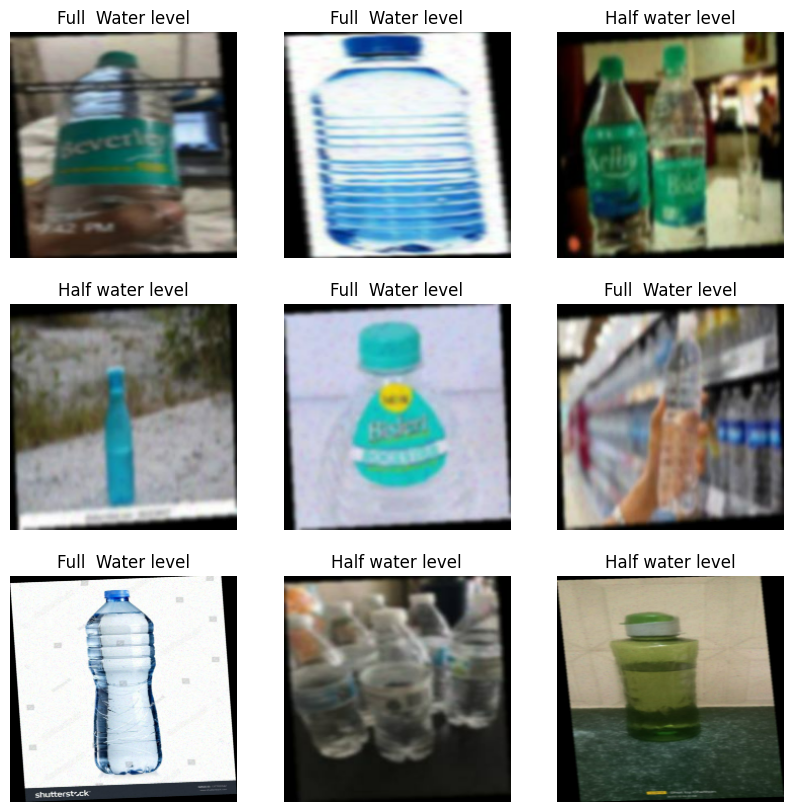

In [53]:
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [54]:
len(dataset)

16

In [55]:
def get_dataset_partitions_tf(ds, train_split=0.75, val_split=0.125, test_split=0.125, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)
    #split the data into validation,training and test dataset

    # Calculate the sizes of each partition
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = int(test_split * ds_size)

    # Shuffle the dataset
    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_size)

    # Extract the three partitions
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size).take(test_size)

    return train_ds, val_ds, test_ds


In [56]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [57]:
len(train_ds)

12

In [58]:
len(val_ds)

2

In [59]:
len(test_ds)

2

### Cache, Shuffle, and Prefetch the Dataset

In [60]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before you feed your images to network, you would be resizing it to the desired size.
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).

In [61]:
#resize_and_rescale
# Create a layer for resizing and normalization
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(*IMAGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)
])


### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [62]:
#compute data augmentation

def data_augmentation(x, training=True):

    # Apply random horizontal flip
    x = tf.image.random_flip_left_right(x)

    # Apply random rotation of 5 degrees
    if training:
        # Generate a random angle between -5 and 5 degrees
        angle = tf.random.uniform(shape=[], minval=-5, maxval=5, dtype=tf.float32)
        # Apply rotation to the image
        x = tf.image.rot90(x, tf.cast(angle / 90, tf.int32))

    # Apply random brightness adjustment
    x = tf.image.random_brightness(x, max_delta=0.1)

    # Apply random saturation adjustment
    x = tf.image.random_saturation(x, lower=0.5, upper=1.5)

    return x

#### Applying Data Augmentation to Train Dataset

In [63]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture
We use a CNN coupled with your chosen activation function in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [64]:
#implement your architecture here

model = tf.keras.Sequential([
    resize_and_rescale,
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # Output layer with 3 classes (full, half, overflowing)
])

model.build((BATCH_SIZE, *IMAGE_SIZE, 3))

In [65]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (32, 224, 224, 3)         0         
                                                                 
 conv2d_10 (Conv2D)          (32, 224, 224, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (32, 112, 112, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (32, 112, 112, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (32, 56, 56, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (32, 56, 56, 128)        

## The known CNN Architecture which is AlexNET

In [66]:

# Define the AlexNet architecture
def AlexNet(input_shape=(224, 224, 3), num_classes=3):
    model = tf.keras.Sequential([

        # Convolutional layer with 96 filters of size 11x11 and stride 4x4
        tf.keras.layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', padding='valid', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='valid'),
        tf.keras.layers.BatchNormalization(),

        # Convolutional layer with 256 filters of size 5x5
        tf.keras.layers.Conv2D(256, (5, 5), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='valid'),
        tf.keras.layers.BatchNormalization(),

        # Convolutional layer with 384 filters of size 3x3
        tf.keras.layers.Conv2D(384, (3, 3), activation='relu', padding='same'),

        # Convolutional layer with 384 filters of size 3x3
        tf.keras.layers.Conv2D(384, (3, 3), activation='relu', padding='same'),

        # Convolutional layer with 256 filters of size 3x3
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='valid'),
        tf.keras.layers.BatchNormalization(),

        # Flatten the output for fully connected layers
        tf.keras.layers.Flatten(),

        # Fully connected layer with 4096 units
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),

        # Fully connected layer with 4096 units
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),

        # Fully connected layer with num_classes units
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Create an instance of the AlexNet model
alexnet_model = AlexNet()

# Display the model summary
alexnet_model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 26, 26, 96)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_3 (Bat  (None, 26, 26, 96)        384       
 chNormalization)                                                
                                                                 
 conv2d_16 (Conv2D)          (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 12, 12, 256)       0         
 ng2D)                                                           
                                                      

### Compiling the Model
use  Optimizer,losses,and your desired metric

In [67]:

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [68]:
alexnet_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fit the Model

In [69]:
#fit your model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/50
12/12 [==============================] - 87s 7s/step - loss: 1.0752 - accuracy: 0.5026 - val_loss: 0.8891 - val_accuracy: 0.6562
Epoch 2/50
12/12 [==============================] - 71s 6s/step - loss: 0.8994 - accuracy: 0.6302 - val_loss: 0.8198 - val_accuracy: 0.6562
Epoch 3/50
12/12 [==============================] - 72s 6s/step - loss: 0.8272 - accuracy: 0.6302 - val_loss: 0.7807 - val_accuracy: 0.6562
Epoch 4/50
12/12 [==============================] - 74s 6s/step - loss: 0.7742 - accuracy: 0.6198 - val_loss: 0.7575 - val_accuracy: 0.6562
Epoch 5/50
12/12 [==============================] - 73s 6s/step - loss: 0.7639 - accuracy: 0.6354 - val_loss: 0.7166 - val_accuracy: 0.7031
Epoch 6/50
12/12 [==============================] - 72s 6s/step - loss: 0.7198 - accuracy: 0.6562 - val_loss: 0.6991 - val_accuracy: 0.6875
Epoch 7/50
12/12 [==============================] - 73s 6s/step - loss: 0.7284 - accuracy: 0.6719 - val_loss: 0.6539 - val_accuracy: 0.7188
Epoch 8/50
12/12 [==

## Fiting AlexNet model

In [70]:
#fit your model
history2 = alexnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/50
12/12 [==============================] - 68s 6s/step - loss: 8.3393 - accuracy: 0.5286 - val_loss: 726.8471 - val_accuracy: 0.6562
Epoch 2/50
12/12 [==============================] - 66s 6s/step - loss: 3.1842 - accuracy: 0.5391 - val_loss: 469.2232 - val_accuracy: 0.6562
Epoch 3/50
12/12 [==============================] - 64s 5s/step - loss: 1.5215 - accuracy: 0.6250 - val_loss: 29.3106 - val_accuracy: 0.6719
Epoch 4/50
12/12 [==============================] - 67s 6s/step - loss: 1.3789 - accuracy: 0.6536 - val_loss: 19.1706 - val_accuracy: 0.6562
Epoch 5/50
12/12 [==============================] - 62s 5s/step - loss: 0.9273 - accuracy: 0.6771 - val_loss: 13.3112 - val_accuracy: 0.6562
Epoch 6/50
12/12 [==============================] - 68s 6s/step - loss: 0.8818 - accuracy: 0.6901 - val_loss: 7.7687 - val_accuracy: 0.6719
Epoch 7/50
12/12 [==============================] - 67s 6s/step - loss: 0.6917 - accuracy: 0.7188 - val_loss: 5.3887 - val_accuracy: 0.6562
Epoch 8/50
12

## compute model evaluation

In [71]:
scores = model.evaluate(test_ds)
scores2 = alexnet_model.evaluate(test_ds)

2/2 [==============================] - 2s 1s/step - loss: 1.2116 - accuracy: 0.5156


In [81]:
# Printing the scores of bboth models

print("The Customized network score: ", scores[1])
print("The AlexNET network score: ", scores2[1])

The Customized network score:  0.96875
The AlexNET network score:  0.515625


### Plotting the Accuracy and Loss Curves

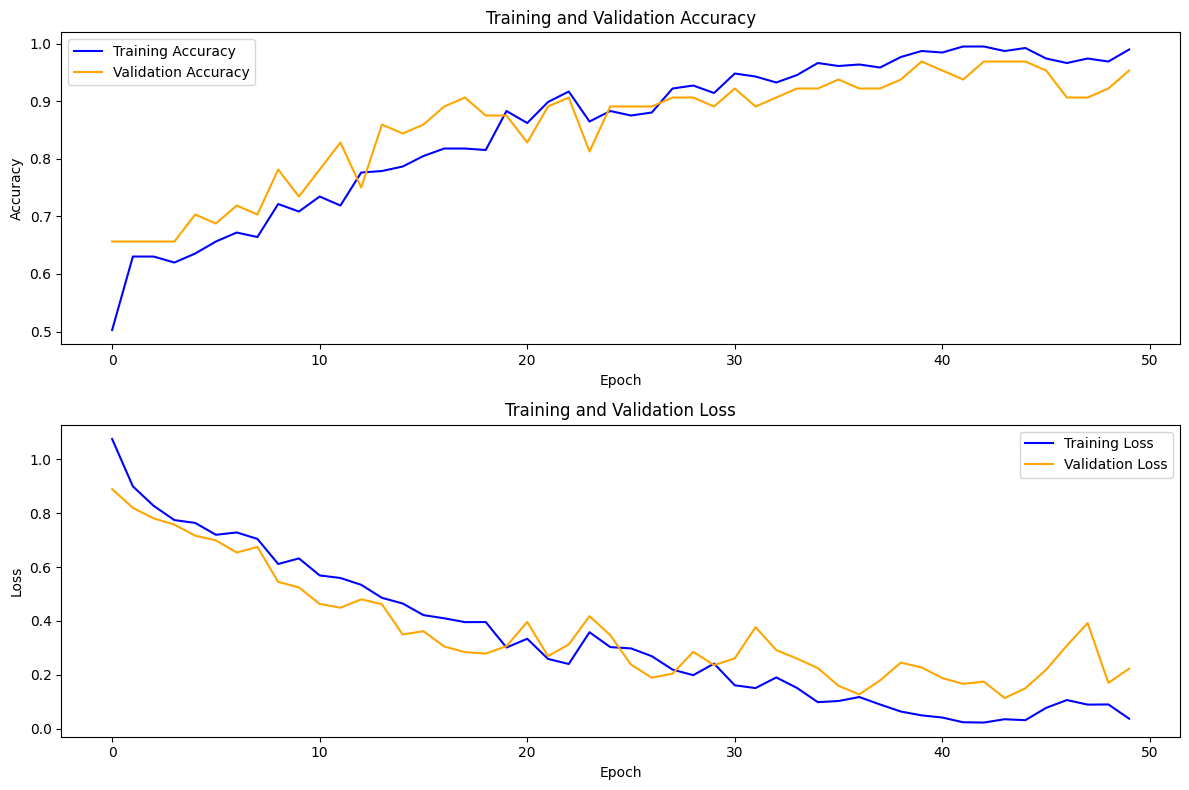

In [73]:

# Plot both accuracy and loss curves on the same plot
plt.figure(figsize=(12, 8))

# Plot accuracy curves
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss curves
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [74]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 12}

In [75]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [76]:
#get your evaluation metrics from history

final_training_loss = history.history['loss'][-1]
final_training_accuracy = history.history['accuracy'][-1]
final_validation_loss = history.history['val_loss'][-1]
final_validation_accuracy = history.history['val_accuracy'][-1]

# Print the final evaluation metrics
print("Final Training Loss:", final_training_loss)
print("Final Training Accuracy:", final_training_accuracy)
print("Final Validation Loss:", final_validation_loss)
print("Final Validation Accuracy:", final_validation_accuracy)

Final Training Loss: 0.037275463342666626
Final Training Accuracy: 0.9895833134651184
Final Validation Loss: 0.22303740680217743
Final Validation Accuracy: 0.953125


### Run prediction on a sample image

first image to predict
actual label: Full  Water level
1/1 [==============================] - 2s 2s/step
predicted label: Full  Water level


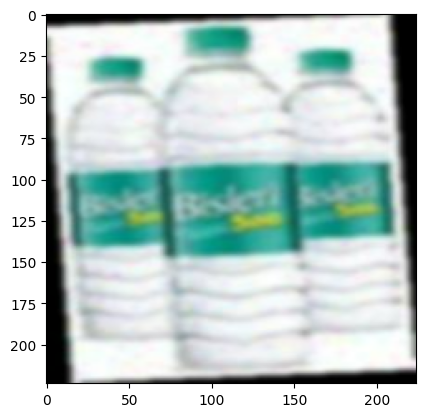

In [77]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [78]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 110ms/step


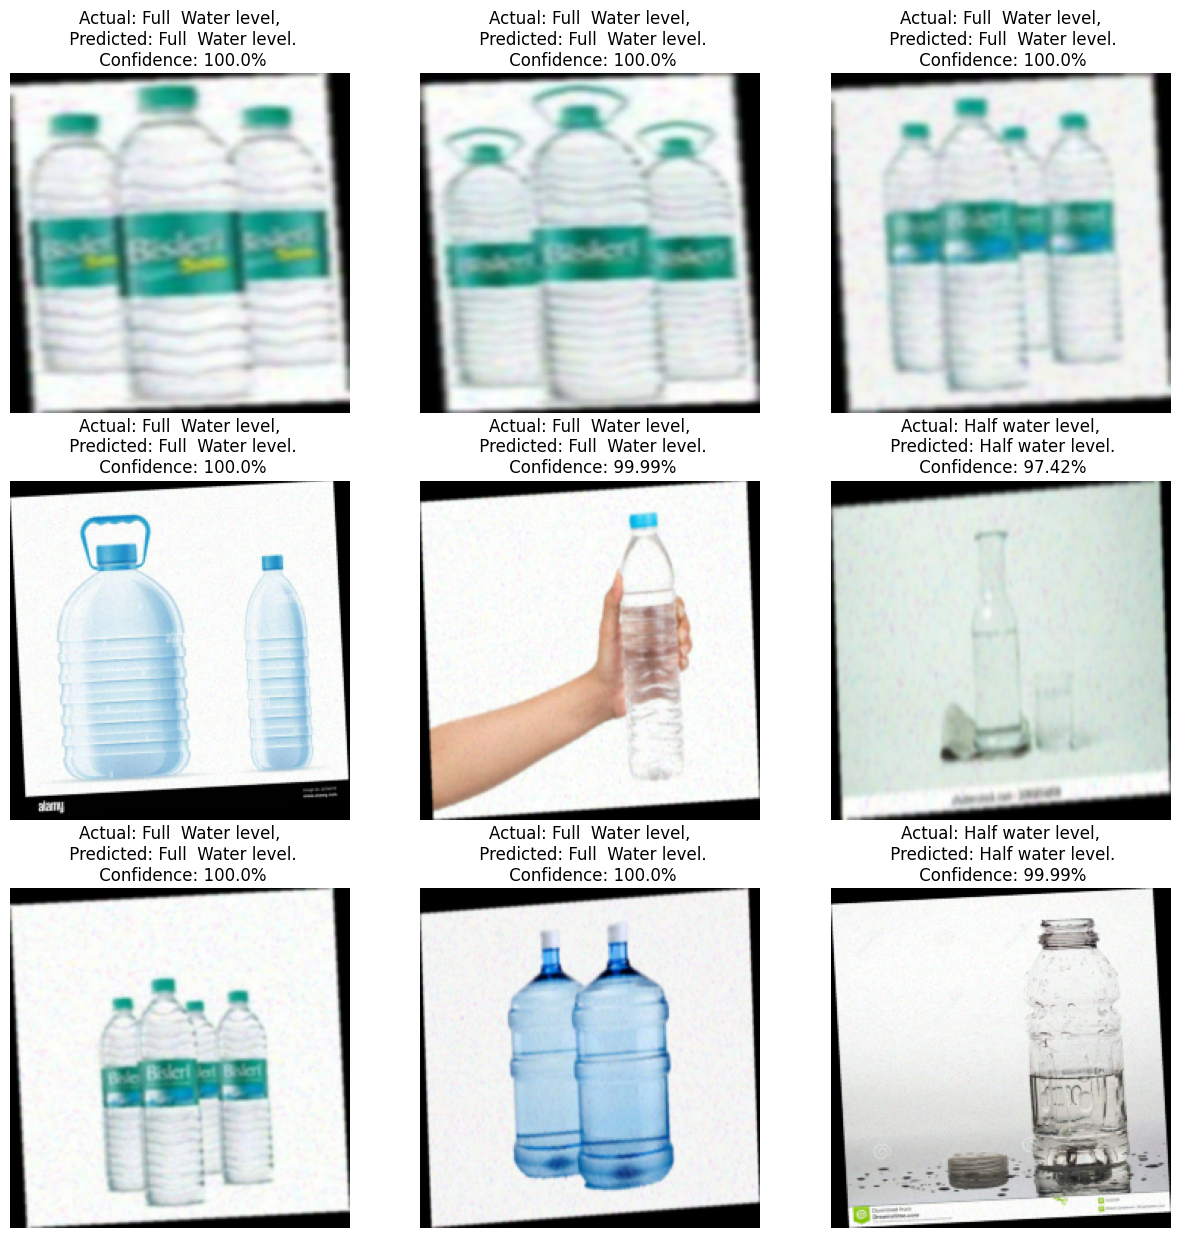

In [79]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [80]:
# Print dataset details
print("Dataset details:")
print("Number of classes:", len(class_names))
print("Class names:", class_names)
print("Number of training examples:", tf.data.Dataset.cardinality(train_ds))
print("Number of validation examples:", tf.data.Dataset.cardinality(val_ds))
print("Number of test examples:", tf.data.Dataset.cardinality(test_ds))

# Print model details
print("Model details:")
print("Input shape:", model.input_shape)
print("Output shape:", model.output_shape)
print("Number of layers:", len(model.layers))


Dataset details:
Number of classes: 3
Class names: ['Full  Water level', 'Half water level', 'Overflowing']
Number of training examples: tf.Tensor(12, shape=(), dtype=int64)
Number of validation examples: tf.Tensor(2, shape=(), dtype=int64)
Number of test examples: tf.Tensor(2, shape=(), dtype=int64)
Model details:
Input shape: (None, 224, 224, 3)
Output shape: (None, 3)
Number of layers: 14


# Choose other known architecture and compare the result you are getting in report